# Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn import cluster
import sklearn
from sklearn.cluster import KMeans
import numpy as np 
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_samples, silhouette_score
from mpl_toolkits import mplot3d
from sklearn.metrics import davies_bouldin_score 

# Load data

In [2]:
emails =  pd.read_csv('email_events_202101071339.csv')
orders =  pd.read_csv('orders_202101071341.csv')
products =  pd.read_csv('products_202101071344.csv')

# merge data

In [3]:
orders_products = pd.merge(orders.copy(), products.copy(), how='left',left_on='product_id', right_on='product_id')
emails_orders_products = pd.merge(emails.copy(), orders_products.copy(), how='left',left_on='customer', right_on='customer')

In [4]:
orders_products.head()

,order_id,customer,created_at,product_id,discount,refunded,price
0,3,2,2019-05-09,1,0.15,0,20
1,7,4,2019-08-11,1,0.15,0,20
2,11,5,2020-06-09,9,0.00,0,30
3,15,8,2020-06-08,7,0.00,0,50
4,19,10,2019-10-31,1,0.00,0,20


In [5]:
emails_orders_products.head()

,event_id,customer,event_name,campaign,event_date,order_id,created_at,product_id,discount,refunded,price
0,140801,1533,Received Email,632ff6402f17a6c96e17bdebffb9dcfa,2020-04-03,2304,2018-08-24,6,0.0,0,35
1,140805,1533,Received Email,4ea861b70be346fb1b3475a8ed953254,2020-02-07,2304,2018-08-24,6,0.0,0,35
2,140809,1533,Received Email,f0d07f7556bf88ab984a1f44e99e48b4,2019-12-13,2304,2018-08-24,6,0.0,0,35
3,140813,1533,Received Email,9a32642f15f2657d118baf7e572b0e81,2019-10-18,2304,2018-08-24,6,0.0,0,35
4,140817,1533,Received Email,bdc4d58ad5fde3ad8c5143452c668f73,2019-08-23,2304,2018-08-24,6,0.0,0,35


In [6]:
# add a new coloum:real price
disc = list(orders_products['discount'])
price = list(orders_products['price'])
orders_products['real_price']= [(1-disc[i])*price[i] for i,j in enumerate(disc)]
orders_products.head()

,order_id,customer,created_at,product_id,discount,refunded,price,real_price
0,3,2,2019-05-09,1,0.15,0,20,17.0
1,7,4,2019-08-11,1,0.15,0,20,17.0
2,11,5,2020-06-09,9,0.00,0,30,30.0
3,15,8,2020-06-08,7,0.00,0,50,50.0
4,19,10,2019-10-31,1,0.00,0,20,20.0


# Customer segmentation

In [7]:
#create a new dataset to apply RFM method
#calculate recency
#sort values of date(created_at) per customer and take the last one
orders_products['created_at'] = pd.to_datetime(orders_products['created_at']) # transform en date format
dR = orders_products.groupby(["customer"], as_index=False).apply(lambda x: x.sort_values(["created_at"], ascending = False).head(1)).reset_index(drop=True)
dR['created_at'] = dR['created_at'].apply(lambda x: x.to_pydatetime())
dR['recency(day)'] = pd.to_datetime('today').to_pydatetime()- dR['created_at']
dR['recency(day)'] = dR['recency(day)'].apply(lambda x: str(x))
dR['recency(day)'] = dR['recency(day)'].apply(lambda x: x.split()[0])
dR = dR[['customer','recency(day)']]

#calculate frequency
dF = orders_products.groupby(by=['customer'], as_index=False).size().reset_index(name='frequency(number)') #number_of_orders_by_customer

#calculate monetory
temp = orders_products.groupby(by=['customer'], as_index=False)['real_price'].sum()
dM = temp.rename(columns = {'real_price':'monetary(total)'})
 
#RFM table
RFM = pd.merge(dR.copy(),dF.copy(),how='left', on ='customer')
RFM = pd.merge(RFM.copy(),dM.copy(),how='left', on ='customer')


In [8]:
RFM.dtypes

customer               int64
recency(day)          object
frequency(number)      int64
monetary(total)      float64
dtype: object

In [9]:
RFM['recency(day)'] = RFM['recency(day)'].astype(int)

In [10]:
RFM.head()

,customer,recency(day),frequency(number),monetary(total)
0,1,350,1,55.00
1,2,292,5,221.75
2,3,538,1,100.00
3,4,513,3,167.00
4,5,215,3,160.00


In [11]:
#Scale features

num_features = ['recency(day)','frequency(number)','monetary(total)']
scaler = StandardScaler()
scaled_matrix = RFM.copy()
for i in num_features:
    scaled_matrix[i] = scaler.fit_transform(RFM[[i]])

In [12]:
scaled_matrix.head()

,customer,recency(day),frequency(number),monetary(total)
0,1,-0.394729,-0.616546,-0.472910
1,2,-0.566931,4.289333,2.688875
2,3,0.163444,-0.616546,0.380345
3,4,0.089219,1.836393,1.650748
4,5,-0.795545,1.836393,1.518019


In [13]:
scaled_matrix.agg(['min', 'max', 'std', 'mean'])

,customer,recency(day),frequency(number),monetary(total)
min,1.00000,-1.291369e+00,-6.165464e-01,-1.212398e+00
max,10000.00000,3.004785e+00,5.515803e+00,5.879103e+00
std,2886.89568,1.000050e+00,1.000050e+00,1.000050e+00
mean,5000.50000,6.342149e-17,2.302603e-17,-4.312106e-17


In [14]:
X = scaled_matrix[scaled_matrix.columns.values[1:]].values
X

array([[-0.394729  , -0.61654639, -0.4729102 ],
       [-0.56693145,  4.289333  ,  2.68887532],
       [ 0.16344447, -0.61654639,  0.38034526],
       ...,
       [ 0.54941549,  1.8363933 ,  1.70763153],
       [-0.89352231, -0.61654639, -0.85213485],
       [-0.48379923,  1.8363933 ,  0.47515142]])

In [15]:
#find optimal number of clusters 

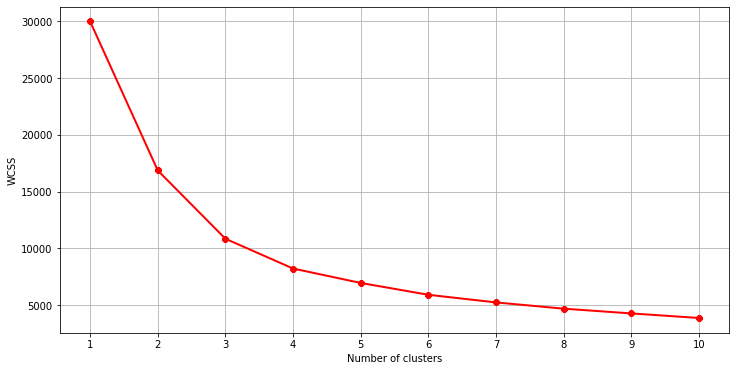

In [16]:
#1. Elbow method
wcss = []
for k in range(1,11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(1,11),wcss, linewidth=2, color="red", marker ="8")
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1,11,1))
plt.ylabel("WCSS")
plt.show()

In [17]:
#3 is the optimal value

Number Of Clusters:   2
Silhouette score value
0.460613571085506
Number Of Clusters:   3
Silhouette score value
0.41376720777594717
Number Of Clusters:   4
Silhouette score value
0.4209408331257815
Number Of Clusters:   5
Silhouette score value
0.42444001278826365
Number Of Clusters:   6
Silhouette score value
0.3734090787940866
Number Of Clusters:   7
Silhouette score value
0.3746151183955497
Number Of Clusters:   8
Silhouette score value
0.3723321726203807
Number Of Clusters:   9
Silhouette score value
0.3779902773223968


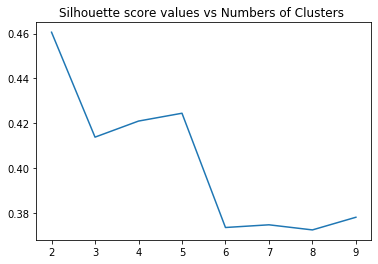

Optimal number of components is:
2


In [18]:
#2.silhouette methode
obs = X
silhouette_score_values=[]
NumberOfClusters=range(2,10)

for i in NumberOfClusters:
    
    classifier=cluster.KMeans(i,init='k-means++', n_init=10, max_iter=300, tol=0.0001, verbose=0, random_state=None, copy_x=True)
    classifier.fit(obs)
    labels= classifier.predict(obs)
    print("Number Of Clusters:  ",i)
    print("Silhouette score value")
    print(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))
    silhouette_score_values.append(sklearn.metrics.silhouette_score(obs,labels ,metric='euclidean', sample_size=None, random_state=None))

plt.plot(NumberOfClusters, silhouette_score_values)
plt.title("Silhouette score values vs Numbers of Clusters ")
plt.show()

Optimal_NumberOf_Components=NumberOfClusters[silhouette_score_values.index(max(silhouette_score_values))]
print("Optimal number of components is:")
print(Optimal_NumberOf_Components)

In [19]:
#Kmeans 

In [20]:
n_clusters = 3
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(X)
clusters_customers = kmeans.predict(X)
centroids = kmeans.cluster_centers_
silhouette_avg = silhouette_score(X, clusters_customers)
print('score de silhouette: {:<.5f}'.format(silhouette_avg))

score de silhouette: 0.41376


In [21]:
n_clusters = 5
kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init=100)
kmeans.fit(X)
clusters_customers = kmeans.predict(X)
centroids = kmeans.cluster_centers_
silhouette_avg = silhouette_score(X, clusters_customers)
print('score de silhouette: {:<.5f}'.format(silhouette_avg))

score de silhouette: 0.42444


In [22]:
pd.DataFrame(pd.Series(clusters_customers).value_counts(), columns = ['number of customers per cluster']).T

,0,3,1,2,4
number of customers per cluster,4234,2409,1667,921,769


In [23]:
#add the cluster column to RFM
clustered_RFM = RFM.copy()
clustered_RFM['cluster'] = clusters_customers
clustered_RFM.head()

,customer,recency(day),frequency(number),monetary(total),cluster
0,1,350,1,55.00,0
1,2,292,5,221.75,4
2,3,538,1,100.00,0
3,4,513,3,167.00,4
4,5,215,3,160.00,4


In [24]:
r=clustered_RFM.groupby('cluster')['recency(day)','frequency(number)','monetary(total)'].agg(['min','max','mean','sum'])
r["cluster_size"]=clustered_RFM.groupby('cluster')['customer'].count().tolist()
r

recency(day)                            frequency(number)      \
                 min   max        mean      sum               min max   
cluster                                                                 
0                 48   585  277.228389  1173785                 1   2   
1                 48   556  252.841032   421486                 2   3   
2                540  1470  841.906623   775396                 2   4   
3                584  1495  890.473225  2145150                 1   2   
4                 48  1308  407.907672   313681                 3   6   

                        monetary(total)                                \
             mean   sum             min    max        mean        sum   
cluster                                                                 
0        1.006613  4262            16.0  100.0   53.150449  225039.00   
1        2.167367  3613            46.0  200.0  110.538992  184268.50   
2        2.209555  2035            50.0  210.0  113.868350  104872.75   
3        1.005812  2423            16.0  100.0   52.227273  125815.50   
4        3.503251  2694            93.0  390.0  207.299415  159413.25   

        cluster_size  
                      
cluster               
0               4234  
1               1667  
2                921  
3               2409  
4                769

Text(0.5, 0.92, 'customer clusters')

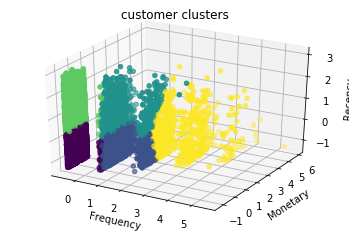

In [25]:
#visualize clusters
fig = plt.figure()
ax = plt.axes(projection='3d')
zdata = X[:, 0]
xdata = X[:, 1]
ydata = X[:, 2]
ax.scatter3D(xdata, ydata, zdata, c=clusters_customers, cmap='viridis')
ax.set_xlabel('Frequency')
ax.set_ylabel('Monetary')
ax.set_zlabel('Recency')
ax.set_title("customer clusters")
#ax.scatter3D(centroids[:, 0],centroids[:, 1],centroids[:, 2], c='black', s=200, alpha=0.5)

In [26]:
#evaluation

DB index : The Davies–Bouldin index (DBI) (introduced by David L. Davies and Donald W. Bouldin in 1979), a metric for evaluating clustering algorithms, is an internal evaluation scheme, where the validation of how well the clustering has been done is made using quantities and features inherent to the dataset. Lower the DB index value, better is the clustering. It also has a drawback. A good value reported by this method does not imply the best information retrieval.

In [27]:
labels = kmeans.labels_ 
print(davies_bouldin_score(X, labels)) #appartient vraiment à chaque cluster, on veut petit

0.8968951949316306


2 0.9493158715458422
3 0.845393694922658
4 0.9005966531700155
5 0.8968951949316306
6 0.9129579609054864
7 0.9575778398569916
8 0.9357468987832276
9 0.9093597409019721
10 0.9125926960327237


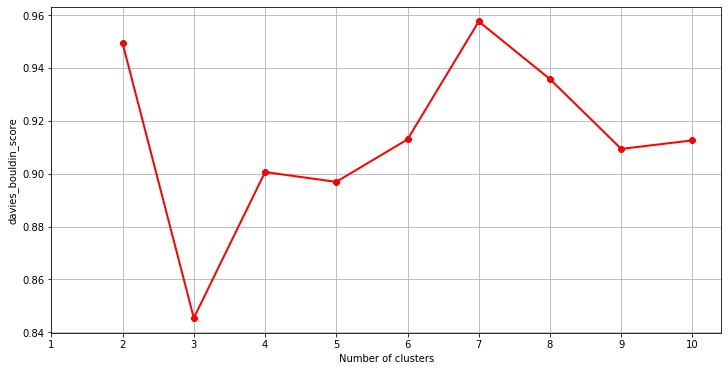

In [28]:
db=[]
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, init="k-means++")
    kmeans.fit(X) 
    labels = kmeans.labels_ 
    db.append(davies_bouldin_score(X, labels))
    print(k,davies_bouldin_score(X, labels))
plt.figure(figsize=(12,6))    
plt.grid()
plt.plot(range(2,11),db, linewidth=2, color="red", marker ="8")
plt.xlabel('Number of clusters')
plt.xticks(np.arange(1,11,1))
plt.ylabel("davies_bouldin_score")
plt.show()


In [29]:
clustered_RFM.head()

,customer,recency(day),frequency(number),monetary(total),cluster
0,1,350,1,55.00,0
1,2,292,5,221.75,4
2,3,538,1,100.00,0
3,4,513,3,167.00,4
4,5,215,3,160.00,4


In [30]:
Customer_product = orders_products[['customer','product_id']]
Customer_product.head()

,customer,product_id
0,2,1
1,4,1
2,5,9
3,8,7
4,10,1


In [31]:
Customer_product[Customer_product.customer==2]

,customer,product_id
0,2,1
3757,2,2
7506,2,2
7514,2,6
11270,2,8


In [32]:
def creat_dict(col1,col2):
    dic = {}
    for i in col1:
        li=[]
        for j,k in enumerate(col2):
            if col1[j]==i:
                li.append(k)
        dic[i] = list(set(li))
    return dic

In [33]:
customer = list(Customer_product['customer'])
product_id = list(Customer_product['product_id'])
customer2 = list(clustered_RFM['customer'])
cluster = list(clustered_RFM['cluster'])
dic1 = creat_dict(customer,product_id)
dic2  = creat_dict(cluster, customer2)

In [34]:
#create table products per clusters 
dic3 ={}
for key, value in dic2.items():
    lst = []
    for a in dic2[key]:
        lst = lst + dic1[a]

    dic3[key]=lst

In [35]:
col1 =[]
col2 =[]
for key, value in dic3.items():
    for j in dic3[key]:
        col1.append(key)
        col2.append(j)

In [36]:
cluster_product = pd.DataFrame({'cluster':col1,'product_id':col2})

In [37]:
cluster_product.head()

,cluster,product_id
0,0,5
1,0,3
2,0,3
3,0,10
4,0,6


In [38]:
len(cluster_product)

14384

In [39]:
cluster_product.cluster.value_counts()

0    4245
1    3407
3    2418
4    2401
2    1913
Name: cluster, dtype: int64

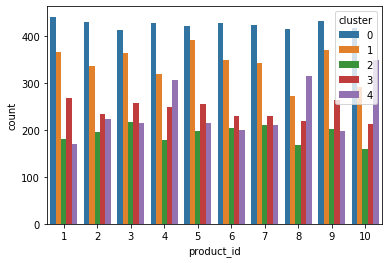

In [40]:
import seaborn as sns
sns.countplot(cluster_product['product_id'],data=cluster_product,hue='cluster')

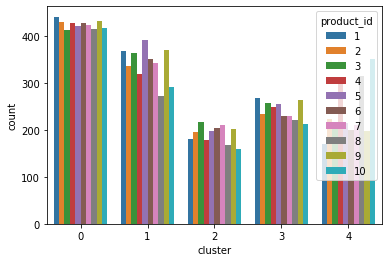

In [44]:
sns.countplot(cluster_product['cluster'],data=cluster_product,hue='product_id')

In [ ]:
sns.pairplot(iris, hue='species', height=2.5);